In [1]:
##The feature engineering was redone starting from the original work and with extra work by us.

In [29]:

#updates:
# added magic feature - boost the AUC by 0.0003

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from plotly.offline import iplot, init_notebook_mode
# General imports

import os, sys, gc, warnings, random, datetime, math

from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

import gc
import os 

#print where those datasets are located 
from sklearn.preprocessing import minmax_scale
# from sklearn.cluster import KMeans

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


#df_trans = pd.read_csv('train_transaction.csv')
df_trans = pd.read_csv('train_transaction.csv',index_col='TransactionID')
df_test_trans = pd.read_csv('test_transaction.csv',index_col='TransactionID')

#record index of test datasets
test_trans_id = df_test_trans.index

#df_id = pd.read_csv('train_identity.csv')
df_id = pd.read_csv('train_identity.csv',index_col='TransactionID')
df_test_id = pd.read_csv('test_identity.csv',index_col='TransactionID')




sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')


In [54]:
#df_id = pd.read_csv('train_identity.csv')
df_id = pd.read_csv('train_identity.csv',index_col='TransactionID')
df_test_id = pd.read_csv('test_identity.csv',index_col='TransactionID')



In [30]:
def id_split(dataframe):
    
    #expand = split and expand to seperate column
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]
    
    #very specifically group device brands to help making decision
    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    #make the device name that are less than 200 to be other
    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    
    #new column to record that this device has id???
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [31]:
df_trans[df_trans['V326']==0]['isFraud']

TransactionID
2987004    0
2987008    0
2987016    0
2987017    0
2987022    0
          ..
3577465    0
3577495    0
3577506    0
3577526    1
3577531    0
Name: isFraud, Length: 72668, dtype: int64

In [32]:

#C sum feature
df_trans["C_sum"] = df_trans.loc[:,'C1':'C14'].sum(axis = 1).astype(np.int8)
df_test_trans["C_sum"] = df_test_trans.loc[:,'C1':'C14'].sum(axis = 1).astype(np.int8)

    
##D1 - D15
df_trans['D_na'] =df_trans.loc[:,'D1':'D14'].isna().sum(axis=1).astype(np.int8)
df_test_trans['D_na'] =df_test_trans.loc[:,'D1':'D14'].isna().sum(axis=1).astype(np.int8)

    
##M1-9
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

df_trans['M_na'] = df_trans[i_cols].isna().sum(axis=1).astype(np.int8)
df_test_trans['M_na'] = df_test_trans[i_cols].isna().sum(axis=1).astype(np.int8)


    
##V_ features
df_trans['V_na'] =df_trans.loc[:,"V1":"V339"].isna().sum(axis=1).astype(np.int8)
df_test_trans['V_na'] =df_test_trans.loc[:,"V1":"V339"].isna().sum(axis=1).astype(np.int8)

##ids 
df_id['id_na'] = df_id.loc[:,"id_01":"id_38"].isna().sum(axis=1).astype(np.int8)
df_test_id['id_na'] = df_test_id.loc[:,"id_01":"id_38"].isna().sum(axis=1).astype(np.int8)




In [33]:
df_id = id_split(df_id)
df_test_id = id_split(df_test_id)

In [34]:

##do not need to include right_index
df_train = df_trans.merge(df_id, how='left', left_index=True,  on='TransactionID')
df_test = df_test_trans.merge(df_test_id, how='left', left_index=True, on='TransactionID')

#add total na for train and test data. 
df_train['tot_na'] = df_train.isna().sum(axis=1).astype(np.int8) 
df_test['tot_na'] = df_test.isna().sum(axis=1).astype(np.int8)

print(df_train.head())
print(df_test.head())


# y_train = df_train['isFraud'].copy()
del df_trans, df_id, df_test_trans, df_test_id
gc.collect()



df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
##Deal with missing data



               isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  ...  device_name  \
TransactionID                                    ...                
2987000        150.0    discover  142.0  credit  ...          NaN   
2987001        150.0  mastercard  102.0  credit  ...          NaN   
2987002        150.0        visa  166.0   debit  ...          NaN   
2987003        150.0  mastercard  117.0   debit  ...          NaN   
2987004        150

In [35]:
df_train.loc[3577531,"screen_height"]

'1600'

In [36]:
#https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm#
#removed V300 feature
useful_features = ['TransactionDT','TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294','id_01',
                   'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id','tot_na','C_sum','D_na','M_na','V_na','id_na']
print(len(useful_features))

273


In [37]:
cols_to_drop = [col for col in df_train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')


In [38]:
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

In [39]:
df_train

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,device_name,device_version,OS_id_30,version_id_30,browser_id_31,version_id_31,screen_width,screen_height,had_id,tot_na
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12
2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16
2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-35
2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19
2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,credit,...,Samsung,NRD90M,Android,7.0,samsung,browser,2220,1080,1.0,-119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16
3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-34
3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29


In [40]:
print(df_train)
print(df_test)


               isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400       68.500000         W  13926    NaN   
2987001              0          86401       29.000000         W   2755  404.0   
2987002              0          86469       59.000000         W   4663  490.0   
2987003              0          86499       50.000000         W  18132  567.0   
2987004              0          86506       50.000000         H   4497  514.0   
...                ...            ...             ...       ...    ...    ...   
3577535              0       15811047       49.000000         W   6550    NaN   
3577536              0       15811049       39.500000         W  10444  225.0   
3577537              0       15811079       30.953125         W  12037  595.0   
3577538              0       15811088      117.000000         W   7826  481.0   
3577539              0      

In [41]:
#new feature regarding TransactionDT
# any repeated transation consecutively under one card1 number is very suspicious. 
df_train= df_train.sort_values(by =['card1','TransactionDT'])

rpt_trans = [1  if df_train.iloc[i,2] == df_train.iloc[i+1,2] or df_train.iloc[i,2] == df_train.iloc[i-1,2] else 0 for i in range(1,df_train.shape[0]-1)]
df_train['rept_trans'] =[0]+ rpt_trans +[0]

df_test= df_test.sort_values(by =['card1','TransactionDT'])

rpt_trans = [1  if df_test.iloc[i,2] == df_test.iloc[i+1,2] or df_test.iloc[i,2] == df_test.iloc[i-1,2] else 0 for i in range(1,df_test.shape[0]-1)]
df_test['rept_trans'] =[0]+ rpt_trans +[0]

In [42]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
########################### Vars
#################################################################################
SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
MAKE_MODEL_TEST = False
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [43]:
remove_features = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,
    ]

base_columns = [col for col in list(df_train) if col not in remove_features]

In [45]:
########################### TransactionDT
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

# Let's add temporary "time variables" for aggregations
# and add normal "time variables"
for df in [df_train, df_test]:
    
    # Temporary variables for aggregation
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = ((df['DT'].dt.year-2017)*12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear).astype(np.int16)
    
    df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
    df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
    df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)
        
    # Possible solo feature
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december']==12).astype(np.int8)

    # Holidays
    df['is_holiday'] = (df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

# Remove temporary features from final list
remove_features += ['DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month']
    
# Total transactions per timeblock
for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([df_train[[col]], df_test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    df_train[col+'_total'] = df_train[col].map(fq_encode)
    df_test[col+'_total']  = df_test[col].map(fq_encode)
    
    # We can't use it as solo feature
    remove_features.append(col+'_total')

In [49]:
def frequency_encoding(df_train, df_test, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([df_train[[col]], df_test[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            df_train[col] = df_train[col].map(fq_encode)
            df_test[col]  = df_test[col].map(fq_encode)            
        else:
            df_train[col+'_fq_enc'] = df_train[col].map(fq_encode)
            df_test[col+'_fq_enc']  = df_test[col].map(fq_encode)
    return df_train, df_test

In [50]:
########################### Client Virtual ID
# Let's add some kind of client uID based on cardID and addr columns
# The value will be very specific for each client so we need to remove it
# from final features. But we can use it for aggregations.
df_train['uid'] = df_train['card1'].astype(str)+'_'+df_train['card2'].astype(str)
df_test['uid'] = df_test['card1'].astype(str)+'_'+df_test['card2'].astype(str)

df_train['uid2'] = df_train['uid'].astype(str)+'_'+df_train['card3'].astype(str)+'_'+df_train['card5'].astype(str)
df_test['uid2'] = df_test['uid'].astype(str)+'_'+df_test['card3'].astype(str)+'_'+df_test['card5'].astype(str)

df_train['uid3'] = df_train['uid2'].astype(str)+'_'+df_train['addr1'].astype(str)+'_'+df_train['addr2'].astype(str)
df_test['uid3'] = df_test['uid2'].astype(str)+'_'+df_test['addr1'].astype(str)+'_'+df_test['addr2'].astype(str)

df_train['uid4'] = df_train['uid3'].astype(str)+'_'+df_train['P_emaildomain'].astype(str)
df_test['uid4'] = df_test['uid3'].astype(str)+'_'+df_test['P_emaildomain'].astype(str)

df_train['uid5'] = df_train['uid3'].astype(str)+'_'+df_train['R_emaildomain'].astype(str)
df_test['uid5'] = df_test['uid3'].astype(str)+'_'+df_test['R_emaildomain'].astype(str)

# Add values remove list
new_columns = ['uid','uid2','uid3','uid4','uid5']
remove_features += new_columns

print('#'*10)
print('Most common uIds:')
for col in new_columns:
    print('#'*10, col)
    print(df_train[col].value_counts()[:10])

# Do Global frequency encoding 
i_cols = ['card1','card2','card3','card5'] + new_columns
df_train, df_test = frequency_encoding(df_train, df_test, i_cols, self_encoding=False)

##########
Most common uIds:
########## uid
7919_194.0     14891
9500_321.0     14112
15885_545.0    10332
17188_321.0    10312
15066_170.0     7918
12695_490.0     7079
6019_583.0      6766
12544_321.0     6760
2803_100.0      6126
7585_553.0      5325
Name: uid, dtype: int64
########## uid2
9500_321.0_150.0_226.0     14112
15885_545.0_185.0_138.0    10332
17188_321.0_150.0_226.0    10312
7919_194.0_150.0_166.0      8844
15066_170.0_150.0_102.0     7918
12695_490.0_150.0_226.0     7079
6019_583.0_150.0_226.0      6766
12544_321.0_150.0_226.0     6760
2803_100.0_150.0_226.0      6126
7919_194.0_150.0_202.0      6047
Name: uid2, dtype: int64
########## uid3
15885_545.0_185.0_138.0_nan_nan       9900
17188_321.0_150.0_226.0_299.0_87.0    5862
12695_490.0_150.0_226.0_325.0_87.0    5766
9500_321.0_150.0_226.0_204.0_87.0     4647
3154_408.0_185.0_224.0_nan_nan        4398
12839_321.0_150.0_226.0_264.0_87.0    3538
16132_111.0_150.0_226.0_299.0_87.0    3523
15497_490.0_150.0_226.0_299.0_87.0

In [56]:
########################### Device info and identity
for df in [df_id, df_test_id]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    
########################### Merge Identity columns
temp_df = df_train[['TransactionID']]
temp_df = temp_df.merge(df_id, on=['TransactionID'], how='left')
del temp_df['TransactionID']
df_train = pd.concat([df_train,temp_df], axis=1)
    
temp_df = df_test[['TransactionID']]
temp_df = temp_df.merge(df_test_id, on=['TransactionID'], how='left')
del temp_df['TransactionID']
df_test = pd.concat([df_test,temp_df], axis=1)

i_cols = [
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31','id_31_device',
          'id_33',
         ]

####### Global Self frequency encoding
# self_encoding=True because 
# we don't need original values anymore
df_train, df_test = frequency_encoding(df_train, df_test, i_cols, self_encoding=True)

KeyError: "None of [Index(['TransactionID'], dtype='object')] are in the [columns]"

In [57]:
########################### ProductCD and M4 Target mean
# As we already have frequency encoded columns
# We can have different global transformation on them
# Target mean?
# We will transform original values as we don't need them
# Leakage over folds?
# Yes, we will have some,
# But in the same time we already have leakage from 
# V columns and card1->card6 columns
# So, no much harm here
for col in ['ProductCD','M4']:
    temp_dict = df_train.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    df_train[col] = df_train[col].map(temp_dict)
    df_test[col]  = df_test[col].map(temp_dict)

In [58]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in list(df_train):
    if df_train[col].dtype=='O':
        print(col)
        df_train[col] = df_train[col].fillna('unseen_before_label')
        df_test[col]  = df_test[col].fillna('unseen_before_label')
        
        df_train[col] = df_train[col].astype(str)
        df_test[col] = df_test[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(df_train[col])+list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col]  = le.transform(df_test[col])
        
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

card4
card6
P_emaildomain
R_emaildomain
M2
M3
M5
M6
M7
M8
M9
id_12
id_15
id_30
id_31
id_33
id_36
id_37
id_38
DeviceType
DeviceInfo
device_name
device_version
OS_id_30
version_id_30
browser_id_31
version_id_31
screen_width
screen_height
uid
uid2
uid3
uid4
uid5


In [59]:
#added card6 - debit credit
#columns_a = ['TransactionAmt', 'id_02', 'D15']
#columns_b = ['card1', 'card2']

#for col_a in columns_a:
#    for col_b in columns_b:
#        for df in [df_train, df_test]:
#            df[f'{col_a}_to_mean_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('mean')
#            df[f'{col_a}_to_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('std')

In [60]:
# New feature - log of transaction amount.
#df_train['TransactionAmt_Log'] = np.log(df_train['TransactionAmt'])
#df_test['TransactionAmt_Log'] = np.log(df_test['TransactionAmt'])

# New feature - decimal part of the transaction amount.
df_train['TransactionAmt_decimal'] = ((df_train['TransactionAmt'] - df_train['TransactionAmt'].astype(int)) * 1000).astype(int)
df_test['TransactionAmt_decimal'] = ((df_test['TransactionAmt'] - df_test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - day of week in which a transaction happened.
df_train['Transaction_day_of_week'] = np.floor((df_train['TransactionDT'] / (3600 * 24) - 1) % 7)
df_test['Transaction_day_of_week'] = np.floor((df_test['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
df_train['Transaction_hour'] = np.floor(df_train['TransactionDT'] / 3600) % 24
df_test['Transaction_hour'] = np.floor(df_test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain',
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card1__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    df_train[feature] = df_train[f1].astype(str) + '_' + df_train[f2].astype(str)
    df_test[feature] = df_test[f1].astype(str) + '_' + df_test[f2].astype(str)

    le = preprocessing.LabelEncoder()
    le.fit(list(df_train[feature].astype(str).values) + list(df_test[feature].astype(str).values))
    df_train[feature] = le.transform(list(df_train[feature].astype(str).values))
    df_test[feature] = le.transform(list(df_test[feature].astype(str).values))

# Encoding - count encoding for both df_train and df_test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_36']:
    df_train[feature + '_count_full'] = df_train[feature].map(pd.concat([df_train[feature], df_test[feature]], ignore_index=True).value_counts(dropna=False))
    df_test[feature + '_count_full'] = df_test[feature].map(pd.concat([df_train[feature], df_test[feature]], ignore_index=True).value_counts(dropna=False))

# Encoding - count encoding separately for df_train and df_test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    df_train[feature + '_count_dist'] = df_train[feature].map(df_train[feature].value_counts(dropna=False))
    df_test[feature + '_count_dist'] = df_test[feature].map(df_test[feature].value_counts(dropna=False))

In [62]:
df_train = df_train.reset_index()
df_train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full,id_36_count_full,id_01_count_dist,id_31_count_dist,id_33_count_dist,id_36_count_dist
0,3230924,0,5787419,23.4375,0.116873,1000,555.0,185.0,2,224.0,...,80404,109960,347386,153109,824959,267353,82170,5806,517251,134066
1,3023634,0,916268,183.0000,0.020399,1001,555.0,150.0,4,226.0,...,80404,956845,719649,553537,824959,819269,446307,450258,517251,449555
2,3151336,0,3504180,29.0000,0.020399,1001,555.0,150.0,4,226.0,...,80404,956845,719649,553537,824959,819269,446307,450258,517251,449555
3,3210739,0,5270458,27.0000,0.020399,1001,555.0,150.0,4,226.0,...,80404,956845,719649,553537,824959,819269,446307,450258,517251,449555
4,3020767,0,842821,150.0000,0.037826,1004,583.0,150.0,4,226.0,...,41503,956845,719649,553537,267648,267353,82170,22000,263,134066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3419314,0,10938204,232.5000,0.020399,18395,543.0,150.0,2,224.0,...,9968,956845,347386,153109,824959,819269,446307,450258,517251,449555
590536,3420746,0,10964952,36.9375,0.020399,18395,543.0,150.0,2,224.0,...,9968,956845,347386,153109,824959,819269,446307,450258,517251,449555
590537,3446622,0,11806909,36.9375,0.020399,18395,543.0,150.0,2,224.0,...,9968,956845,347386,153109,824959,819269,446307,450258,517251,449555
590538,3480204,0,12865537,36.9375,0.020399,18395,543.0,150.0,2,224.0,...,9968,956845,347386,153109,824959,819269,446307,450258,517251,449555


In [63]:


#k fold cross validation target mean coding to avoid overfitting

N_SPLITS = 5
SEED = 6

folds = KFold(n_splits=N_SPLITS,shuffle = False, random_state=SEED)
# Test Data and expport DF
  
score = 0
y_result = 0

mean_of_target = df_train['isFraud'].mean()

target_mean_list =['card1','card2','addr1','addr1__card1','card1__card5','card1__P_emaildomain']

# kfold target mean encoding for regularisation

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    print('Fold:',fold_+1)
    tr_x = df_train.iloc[trn_idx,:] 
    vl_x = df_train.iloc[val_idx,:]  
    
    for col in target_mean_list:
        print(col)
        df_train.loc[val_idx,f'{col}_target_enc'] = vl_x[col].map(tr_x.groupby(col)['isFraud'].mean())
        
        df_train[f'{col}_target_enc'].fillna(mean_of_target, inplace = True)
                                                        
for col in target_mean_list:
                                                            
    df_test[f'{col}_target_enc'] = df_test[col].map(df_train.groupby(col)[f'{col}_target_enc'].mean())

    df_test[f'{col}_target_enc'].fillna(mean_of_target, inplace = True)

    
    

Fold: 1
card1
card2
addr1
addr1__card1
card1__card5
card1__P_emaildomain
Fold: 2
card1
card2
addr1
addr1__card1
card1__card5
card1__P_emaildomain
Fold: 3
card1
card2
addr1
addr1__card1
card1__card5
card1__P_emaildomain
Fold: 4
card1
card2
addr1
addr1__card1
card1__card5
card1__P_emaildomain
Fold: 5
card1
card2
addr1
addr1__card1
card1__card5
card1__P_emaildomain


In [65]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
    return train_df, test_df

def uid_aggregation_and_normalization(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            
            new_norm_col_name = col+'_'+main_column+'_std_norm'
            norm_cols = []
            
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
                norm_cols.append(new_col_name)
            
            train_df[new_norm_col_name] = (train_df[main_column]-train_df[norm_cols[0]])/train_df[norm_cols[1]]
            test_df[new_norm_col_name]  = (test_df[main_column]-test_df[norm_cols[0]])/test_df[norm_cols[1]]          
            
            del train_df[norm_cols[0]], train_df[norm_cols[1]]
            del test_df[norm_cols[0]], test_df[norm_cols[1]]
                                              
    return train_df, test_df

In [66]:
########################### D Columns
# From columns description we know that
# D1-D15: timedelta, such as days between previous transaction, etc.
# 1. I can't imagine normal negative timedelta values (Let's clip Values)
# 2. Normalize (Min-Max, Standard score) All D columns, except D1,D2,D9
# 3. Do some aggregations based on uIDs
# 4. Freaquency encoding
# 5. D1,D2 are clipped by max df_train values (let's scale it)
i_cols = ['D'+str(i) for i in range(1,16)]
uids = ['uid','uid2','uid3','uid4','uid5','bank_type']
aggregations = ['mean','std']

####### uIDs aggregations
df_train, df_test = uid_aggregation(df_train, df_test, i_cols, uids, aggregations)

####### Cleaning Neagtive values and columns transformations
for df in [df_train, df_test]:

    for col in i_cols:
        df[col] = df[col].clip(0) 
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

####### Values Normalization
i_cols.remove('D1')
i_cols.remove('D2')
i_cols.remove('D9')
periods = ['DT_D','DT_W','DT_M']
for df in [df_train, df_test]:
    df = values_normalization(df, periods, i_cols)

for col in ['D1','D2']:
    for df in [df_train, df_test]:
        df[col+'_scaled'] = df[col]/df_train[col].max()
        
####### Global Self frequency encoding
# self_encoding=True because 
# we don't need original values anymore
i_cols = ['D'+str(i) for i in range(1,16)]
df_train, df_test = frequency_encoding(df_train, df_test, i_cols, self_encoding=True)

KeyError: "['bank_type'] not in index"

In [67]:
#label encoding the rest 
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        le = preprocessing.LabelEncoder()
        le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
        df_train[col] = le.transform(list(df_train[col].astype(str).values))
        df_test[col] = le.transform(list(df_test[col].astype(str).values))

In [68]:
#why sort ??
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud']

X_test = df_test.drop(['TransactionDT'], axis=1)



8

In [69]:
########################### Minification
df_train.to_pickle('df_train.pkl')
df_test.to_pickle('df_test.pkl')

remove_features = pd.DataFrame(remove_features, columns=['features_to_remove'])
remove_features.to_pickle('remove_features.pkl')

del df_train, df_test
gc.collect()

NameError: name 'df_train' is not defined

In [ ]:
X_test

In [70]:
from sklearn.model_selection import KFold
import lightgbm as lgb
##The following will carry out automated parameters optimisation for mainly accuray and overfitting related parameters based on Bayesian optimisation
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics





In [71]:
##Those parameters are the optimised ones for 4 hours 
#small min_data, large min_leaves, small learning rate, gbdt. 
#https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again
best_param = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [72]:
sum(X_train['rept_trans'])

118712

In [80]:
X_train = X_train.drop(['DT'], axis=1)
X_test = X_test.drop(['DT'], axis=1)

In [81]:
for i in X_train.columns:
    print(i)

TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
P_emaildomain
R_emaildomain
C1
C2
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D8
D9
D10
D11
D12
D13
D14
D15
M2
M3
M4
M5
M6
M7
M8
M9
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V17
V19
V20
V29
V30
V33
V34
V35
V36
V37
V38
V40
V44
V45
V46
V47
V48
V49
V51
V52
V53
V54
V56
V58
V59
V60
V61
V62
V63
V64
V69
V70
V71
V72
V73
V74
V75
V76
V78
V80
V81
V82
V83
V84
V85
V87
V90
V91
V92
V93
V94
V95
V96
V97
V99
V100
V126
V127
V128
V130
V131
V138
V139
V140
V143
V145
V146
V147
V149
V150
V151
V152
V154
V156
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167
V169
V170
V171
V172
V173
V175
V176
V177
V178
V180
V182
V184
V187
V188
V189
V195
V197
V200
V201
V202
V203
V204
V205
V206
V207
V208
V209
V210
V212
V213
V214
V215
V216
V217
V219
V220
V221
V222
V223
V224
V225
V226
V227
V228
V229
V231
V233
V234
V238
V239
V242
V243
V244
V245
V246
V247
V249
V251
V253
V256
V257
V258
V259
V261
V262
V263
V264
V265
V266
V267
V268
V270
V271
V272
V273


In [82]:
N_SPLITS = 5
SEED = 6

columns = X_train.columns
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

folds = KFold(n_splits=N_SPLITS, random_state=SEED)
# Test Data and expport DF
  
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])

score = 0
y_result = 0
print("running")
# use stratified fold to ensure the split datasets have same portion of postive and negative data.
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print('Fold:',fold_+1)
    tr_x, tr_y = X_train.iloc[trn_idx,:], y_train.iloc[trn_idx]    
    vl_x, v_y = X_train.iloc[val_idx,:], y_train.iloc[val_idx]    
    train_data = lgb.Dataset(tr_x, label=tr_y)
    valid_data = lgb.Dataset(vl_x, label=v_y)  
        
    #this will run very slow. 
    num_round =5000
        
    #here valid sets are the criteria for stopping, when the auc score for valid sets do not improve after num_round, then it will stop. 
    estimator = lgb.train(
            best_param,
            train_data, 
            num_round,
            valid_sets = [train_data,valid_data],
            #print evaluation at each step
            verbose_eval = 10,
            )

    y_pred_valid = estimator.predict(vl_x)
    y_oof[val_idx] = y_pred_valid
    print(f"Fold {fold_ + 1} | AUC: {roc_auc_score(v_y, y_pred_valid)}")
    
    #score is the roc_auc of valid pred 
    score += roc_auc_score(v_y, y_pred_valid) / N_SPLITS
    y_result += estimator.predict(X_test) / N_SPLITS
    # we are not sure what fold is best for us
    # so we will average prediction results 
    # over folds; meaning each fold we predict test data and then get average.
    
    feature_importances[f'fold_{fold_ + 1}'] = estimator.feature_importance()

    del train_data, valid_data
    gc.collect()
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")
    #print('LOG loss', metrics.log_loss(RESULTS['isFraud'], RESULTS['stratifiedkfold']))


running
Fold: 1
Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.94676	valid_1's auc: 0.857529
[20]	training's auc: 0.957884	valid_1's auc: 0.863769
[30]	training's auc: 0.964813	valid_1's auc: 0.870379
[40]	training's auc: 0.967446	valid_1's auc: 0.874382
[50]	training's auc: 0.971072	valid_1's auc: 0.876252
[60]	training's auc: 0.973252	valid_1's auc: 0.877216
[70]	training's auc: 0.975387	valid_1's auc: 0.878521
[80]	training's auc: 0.977551	valid_1's auc: 0.878609
[90]	training's auc: 0.979663	valid_1's auc: 0.879456
[100]	training's auc: 0.981077	valid_1's auc: 0.880524
[110]	training's auc: 0.982552	valid_1's auc: 0.881134
[120]	training's auc: 0.983895	valid_1's auc: 0.88187
[130]	training's auc: 0.984839	valid_1's auc: 0.882216
[140]	training's auc: 0.98579	valid_1's auc: 0.882734
[150]	training's auc: 0.986823	valid_1's auc: 0.88328
[160]	training's auc: 0.987801	valid_1's auc: 0.884077
[170]	training's auc: 0.988599	valid_1's auc: 0.884847

[1510]	training's auc: 1	valid_1's auc: 0.903827
[1520]	training's auc: 1	valid_1's auc: 0.903805
[1530]	training's auc: 1	valid_1's auc: 0.903809
[1540]	training's auc: 1	valid_1's auc: 0.903953
[1550]	training's auc: 1	valid_1's auc: 0.903942
[1560]	training's auc: 1	valid_1's auc: 0.903995
[1570]	training's auc: 1	valid_1's auc: 0.904126
[1580]	training's auc: 1	valid_1's auc: 0.904211
[1590]	training's auc: 1	valid_1's auc: 0.904285
[1600]	training's auc: 1	valid_1's auc: 0.90432
[1610]	training's auc: 1	valid_1's auc: 0.904433
[1620]	training's auc: 1	valid_1's auc: 0.904534
[1630]	training's auc: 1	valid_1's auc: 0.904661
[1640]	training's auc: 1	valid_1's auc: 0.904751
[1650]	training's auc: 1	valid_1's auc: 0.904873
[1660]	training's auc: 1	valid_1's auc: 0.904922
[1670]	training's auc: 1	valid_1's auc: 0.905077
[1680]	training's auc: 1	valid_1's auc: 0.905158
[1690]	training's auc: 1	valid_1's auc: 0.905242
[1700]	training's auc: 1	valid_1's auc: 0.905383
[1710]	training's auc

[1100]	training's auc: 0.999998	valid_1's auc: 0.926647
[1110]	training's auc: 0.999998	valid_1's auc: 0.926786
[1120]	training's auc: 0.999998	valid_1's auc: 0.926864
[1130]	training's auc: 0.999998	valid_1's auc: 0.926905
[1140]	training's auc: 0.999999	valid_1's auc: 0.926919
[1150]	training's auc: 0.999999	valid_1's auc: 0.926942
[1160]	training's auc: 0.999999	valid_1's auc: 0.927057
[1170]	training's auc: 0.999999	valid_1's auc: 0.927088
[1180]	training's auc: 0.999999	valid_1's auc: 0.927096
[1190]	training's auc: 0.999999	valid_1's auc: 0.927104
[1200]	training's auc: 0.999999	valid_1's auc: 0.927148
[1210]	training's auc: 0.999999	valid_1's auc: 0.927277
[1220]	training's auc: 1	valid_1's auc: 0.927251
[1230]	training's auc: 1	valid_1's auc: 0.927263
[1240]	training's auc: 1	valid_1's auc: 0.927326
[1250]	training's auc: 1	valid_1's auc: 0.927393
[1260]	training's auc: 1	valid_1's auc: 0.927455
[1270]	training's auc: 1	valid_1's auc: 0.927458
[1280]	training's auc: 1	valid_1's

Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.94618	valid_1's auc: 0.883472
[20]	training's auc: 0.958275	valid_1's auc: 0.894924
[30]	training's auc: 0.964567	valid_1's auc: 0.898893
[40]	training's auc: 0.968085	valid_1's auc: 0.900679
[50]	training's auc: 0.970824	valid_1's auc: 0.901621
[60]	training's auc: 0.972826	valid_1's auc: 0.902913
[70]	training's auc: 0.975355	valid_1's auc: 0.904127
[80]	training's auc: 0.977527	valid_1's auc: 0.904762
[90]	training's auc: 0.979338	valid_1's auc: 0.905418
[100]	training's auc: 0.980867	valid_1's auc: 0.90581
[110]	training's auc: 0.982436	valid_1's auc: 0.906253
[120]	training's auc: 0.98359	valid_1's auc: 0.906673
[130]	training's auc: 0.984644	valid_1's auc: 0.907275
[140]	training's auc: 0.985592	valid_1's auc: 0.907646
[150]	training's auc: 0.986634	valid_1's auc: 0.907762
[160]	training's auc: 0.98752	valid_1's auc: 0.908003
[170]	training's auc: 0.988408	valid_1's auc: 0.908051
[180]	training'

In [ ]:
##trick here 
##for oof = 0.93547, LB score is 0.9458
##for oof = 0.936, LB score is 0.945

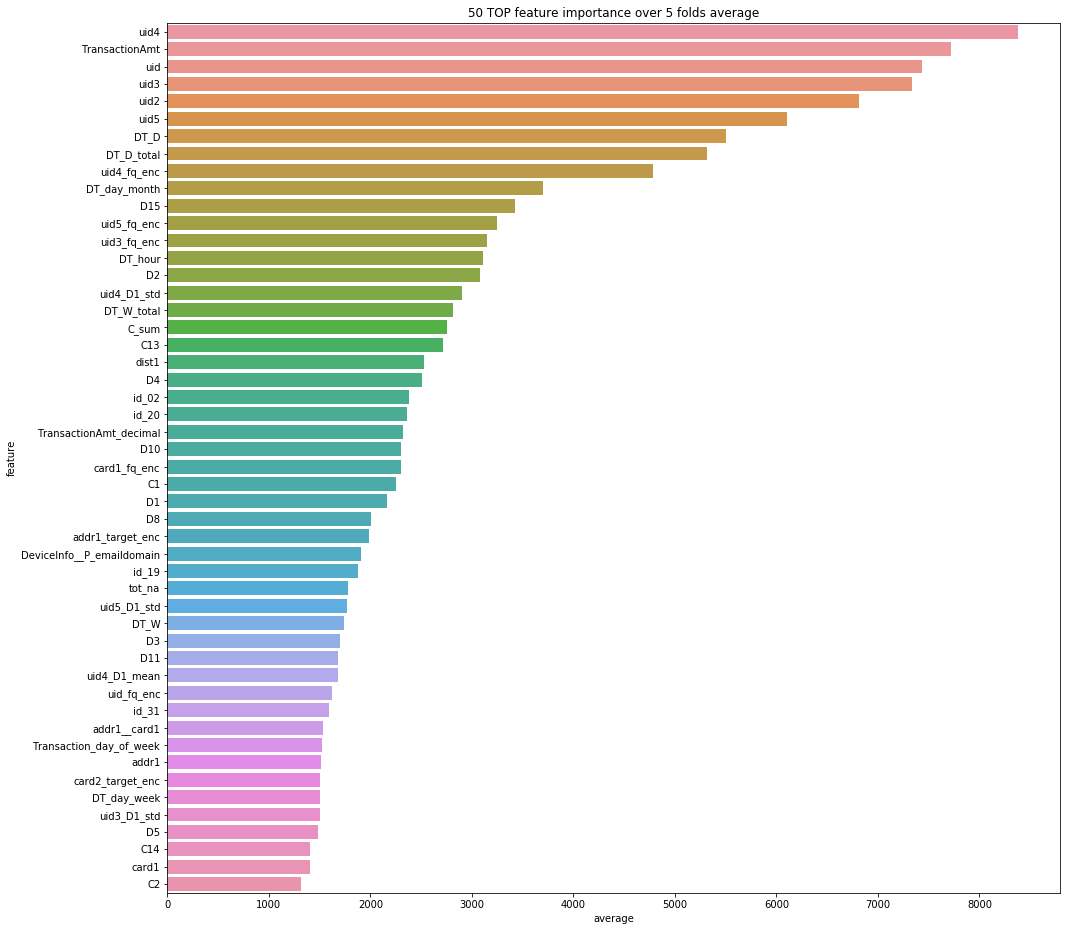

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
##take the mean of each feature importance of all folds. 
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [84]:

sub = pd.DataFrame(columns=['TransactionID','isFraud'])
sub['TransactionID'] = X_test.index
sub['isFraud'] = y_result
sub




sub.to_csv("submission58th-updated-03.csv",index=False)

sum(y_result>0.1)


19908

In [ ]:
sum(y_result>0.5)
